<a href="https://colab.research.google.com/github/riponazad/OOD_Detection/blob/main/AE_OOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

# Download and load the OOD data
oodset = datasets.MNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=64, shuffle=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(trainset)
print(testset)
print(oodset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
class MultilayerAutoEncoder(nn.Module):
    
    def __init__(self):
        super(MultilayerAutoEncoder, self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28,28),
            nn.ReLU(),
            nn.Linear(28,250),
            nn.ReLU(),
            #Latent View
            nn.Linear(250,10)
            )
        
        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,28*28)
        )
        
    def forward(self,x):
        #x = x.reshape(64,1,28*28)
        #print(x.size())
        x = self.encoder(x)
        x = torch.sigmoid(x)
        x = self.decoder(x)
        #x = x.reshape(64,1,28,28)
        return x

In [5]:
# creating model,and defining optimizer and loss
model = MultilayerAutoEncoder()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

We're using => cuda:0
MultilayerAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
  )
)


In [6]:
def output_label(label):
    output_mapping = {
                 0: "Zero",
                 1: "One",
                 2: "Two",
                 3: "Three",
                 4: "Four", 
                 5: "Five", 
                 6: "Six",
                 7: "Seven",
                 8: "Eight",
                 9: "Nine"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Six
torch.Size([64, 1, 28, 28]) torch.Size([64])


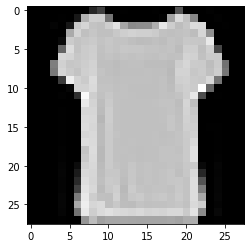

In [7]:
image, label = next(iter(train_loader))
plt.imshow(image[10].squeeze(), cmap="gray")
print(output_label(label[10]))
print(image.size(), label.size())

In [8]:
print("Begin training.")
for e in tqdm(range(10)):
    # TRAINING
    train_epoch_loss = 0
    #train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        X_train_batch = X_train_batch.view(X_train_batch.size(0), -1)
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, X_train_batch)
        #train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        #train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.12440



Epoch 01: | Train Loss: 0.07823



Epoch 02: | Train Loss: 0.07112



Epoch 03: | Train Loss: 0.06747



Epoch 04: | Train Loss: 0.06508



Epoch 05: | Train Loss: 0.06338



Epoch 06: | Train Loss: 0.06208



Epoch 07: | Train Loss: 0.06103



Epoch 08: | Train Loss: 0.06012



Epoch 09: | Train Loss: 0.05946



In [9]:
def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.numpy().reshape(28, 28), cmap='gray')

In [10]:
#TESTING
test_epoch_loss = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        test_loss = criterion(y_test_pred, x_batch)
        test_epoch_loss += test_loss.item()
    print(f'Test Loss: {test_epoch_loss/len(test_loader):.5f}')


Test Loss: 0.05984


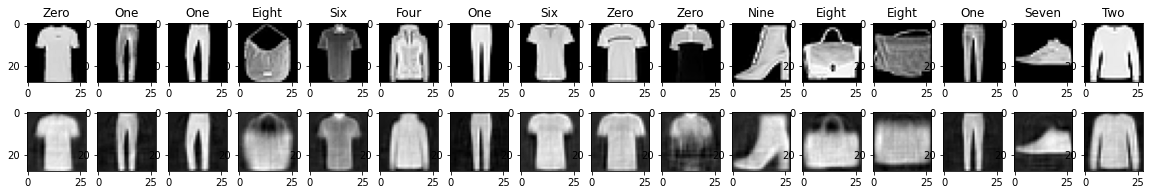

In [11]:
plt.figure(figsize=(20, 3))
for i in range(16):
    plt.subplot(2, 16, i+1).set_title(output_label(y_batch[i]))
    show_torch_image(x_batch[i].cpu())
for i in range(16):
    plt.subplot(2, 16, 16+i+1)
    show_torch_image(y_test_pred[i].detach().cpu())

In [12]:
#TESTING
ood_epoch_loss = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_epoch_loss += ood_loss.item()
    print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')


Test Loss: 0.23637


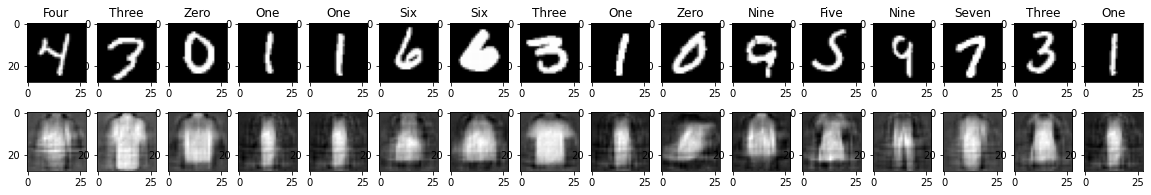

In [13]:
plt.figure(figsize=(20, 3))
for i in range(16):
    plt.subplot(2, 16, i+1).set_title(output_label(y_batch[i]))
    show_torch_image(x_batch[i].cpu())
for i in range(16):
    plt.subplot(2, 16, 16+i+1)
    show_torch_image(y_test_pred[i].detach().cpu())

In [37]:
# Updating batch size of test and OOD data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=1, shuffle=True)

# Download and load the OOD data
oodset = datasets.MNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=1, shuffle=True)

In [38]:
#Detecting OOD using avg_loss of AE as threshold
mse_loss = []
ood_val = []
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(1)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


Test Loss: 0.23648
number of correct ood detection: 9041
accuracy: 0.9041


In [39]:
#Detecting OOD using avg_loss of AE as threshold
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(0)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(test_loader):.5f}')
print(f'number of incorrect ood detection: {ood_sum}')
print(f'accuracy: {1-ood_sum/num_samples}')


Test Loss: 0.05988
number of incorrect ood detection: 344
accuracy: 0.9656


In [40]:
# Download and load the OOD data
oodset = datasets.MNIST('./data', download=True, train=True, transform=transform)
ood_loader = DataLoader(oodset, batch_size=1, shuffle=True)

In [41]:
#Detecting OOD using avg_loss of AE as threshold
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(1)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


Test Loss: 0.23581
number of correct ood detection: 54033
accuracy: 0.90055


In [42]:
def plot_roc_curve(fpr, tpr, str):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str+'\nReceiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.99


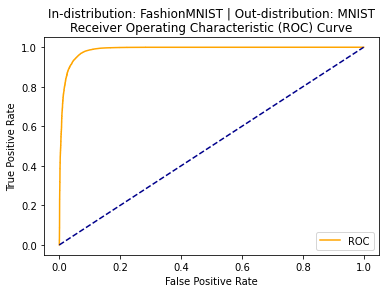

In [43]:
str ='In-distribution: FashionMNIST | Out-distribution: MNIST'
auc = roc_auc_score(ood_val, mse_loss)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(ood_val, mse_loss)
plot_roc_curve(fpr, tpr, str)

In [44]:
print(len(ood_val), len(mse_loss))

80000 80000


In [45]:
# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

# Download and load the OOD data
oodset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=64, shuffle=True)

In [46]:
# creating model,and defining optimizer and loss
model = MultilayerAutoEncoder()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

We're using => cuda:0
MultilayerAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
  )
)


In [47]:
print("Begin training.")
for e in tqdm(range(10)):
    # TRAINING
    train_epoch_loss = 0
    #train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        X_train_batch = X_train_batch.view(X_train_batch.size(0), -1)
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, X_train_batch)
        #train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        #train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.18220



Epoch 01: | Train Loss: 0.11630



Epoch 02: | Train Loss: 0.10478



Epoch 03: | Train Loss: 0.09857



Epoch 04: | Train Loss: 0.09396



Epoch 05: | Train Loss: 0.09097



Epoch 06: | Train Loss: 0.08858



Epoch 07: | Train Loss: 0.08690



Epoch 08: | Train Loss: 0.08532



Epoch 09: | Train Loss: 0.08413



In [48]:
#TESTING
test_epoch_loss = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        test_loss = criterion(y_test_pred, x_batch)
        test_epoch_loss += test_loss.item()
    print(f'Test Loss: {test_epoch_loss/len(test_loader):.5f}')


Test Loss: 0.08379


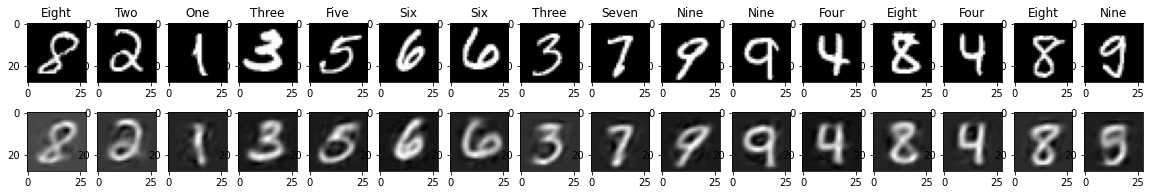

In [49]:
plt.figure(figsize=(20, 3))
for i in range(16):
    plt.subplot(2, 16, i+1).set_title(output_label(y_batch[i]))
    show_torch_image(x_batch[i].cpu())
for i in range(16):
    plt.subplot(2, 16, 16+i+1)
    show_torch_image(y_test_pred[i].detach().cpu())

In [50]:
#TESTING
ood_epoch_loss = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_epoch_loss += ood_loss.item()
    print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')


Test Loss: 0.42236


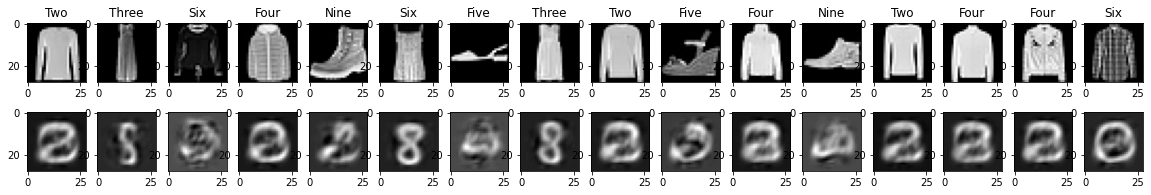

In [51]:
plt.figure(figsize=(20, 3))
for i in range(16):
    plt.subplot(2, 16, i+1).set_title(output_label(y_batch[i]))
    show_torch_image(x_batch[i].cpu())
for i in range(16):
    plt.subplot(2, 16, 16+i+1)
    show_torch_image(y_test_pred[i].detach().cpu())

In [52]:
# Updating batch size of test and OOD data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=1, shuffle=True)

# Download and load the OOD data
oodset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=1, shuffle=True)

In [53]:
#Detecting OOD using avg_loss of AE as threshold
mse_loss = []
ood_val = []
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(1)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


Test Loss: 0.42235
number of correct ood detection: 9143
accuracy: 0.9143


In [54]:
#Detecting OOD using avg_loss of AE as threshold
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(0)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(test_loader):.5f}')
print(f'number of incorrect ood detection: {ood_sum}')
print(f'accuracy: {1-ood_sum/num_samples}')


Test Loss: 0.08374
number of incorrect ood detection: 597
accuracy: 0.9403


In [55]:
# Download and load the OOD data
oodset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
ood_loader = DataLoader(oodset, batch_size=1, shuffle=True)

In [56]:
#Detecting OOD using avg_loss of AE as threshold
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(1)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


Test Loss: 0.42100
number of correct ood detection: 54845
accuracy: 0.9140833333333334


AUC: 0.98


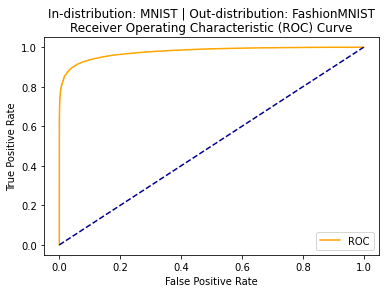

In [57]:
str ='In-distribution: MNIST | Out-distribution: FashionMNIST'
auc = roc_auc_score(ood_val, mse_loss)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(ood_val, mse_loss)
plot_roc_curve(fpr, tpr, str)

In [58]:
print(len(ood_val), len(mse_loss))

80000 80000


In [66]:
# Download and load the OOD data
oodset = datasets.EMNIST('./data',split='letters', download=True, train=True, transform=transform)
ood_loader = DataLoader(oodset, batch_size=64, shuffle=True)

In [67]:
print(oodset)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [74]:
#TESTING
ood_epoch_loss = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_epoch_loss += ood_loss.item()
    print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')


Test Loss: 0.25292


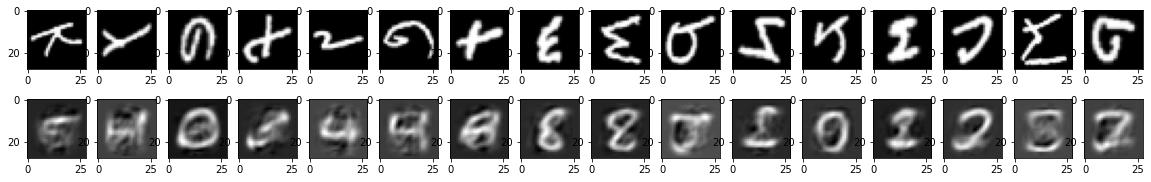

In [75]:
plt.figure(figsize=(20, 3))
for i in range(16):
    plt.subplot(2, 16, i+1)
    show_torch_image(x_batch[i].cpu())
for i in range(16):
    plt.subplot(2, 16, 16+i+1)
    show_torch_image(y_test_pred[i].detach().cpu())

In [77]:
# Download and load the OOD data
oodset = datasets.EMNIST('./data',split='letters', download=True, train=True, transform=transform)
ood_loader = DataLoader(oodset, batch_size=1, shuffle=True)

In [78]:
#Detecting OOD using avg_loss of AE as threshold
mse_loss = []
ood_val = []
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(1)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


Test Loss: 0.25292
number of correct ood detection: 106417
accuracy: 0.8527003205128205


In [79]:
# Download and load the OOD data
oodset = datasets.EMNIST('./data',split='letters', download=True, train=False, transform=transform)
ood_loader = DataLoader(oodset, batch_size=1, shuffle=True)

In [80]:
#Detecting OOD using avg_loss of AE as threshold
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(ood_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(1)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(ood_loader):.5f}')
print(f'number of correct ood detection: {ood_sum}')
print(f'accuracy: {ood_sum/num_samples}')


Test Loss: 0.25220
number of correct ood detection: 17684
accuracy: 0.8501923076923077


In [81]:
#Detecting OOD using avg_loss of AE as threshold
ood_epoch_loss = 0
ood_sum = 0
num_samples = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)
        ood_loss = criterion(y_test_pred, x_batch)
        ood_loss = ood_loss.cpu().numpy()
        mse_loss.append(ood_loss)
        ood_val.append(0)
        num_samples += len(x_batch)
        if ood_loss.item()>0.15:
          ood_sum +=1
        ood_epoch_loss += ood_loss.item()
print(f'Test Loss: {ood_epoch_loss/len(test_loader):.5f}')
print(f'number of incorrect ood detection: {ood_sum}')
print(f'accuracy: {1-ood_sum/num_samples}')


Test Loss: 0.08374
number of incorrect ood detection: 597
accuracy: 0.9403


AUC: 0.96


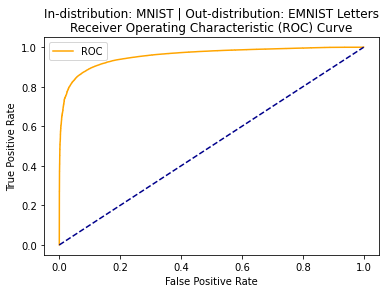

In [82]:
str ='In-distribution: MNIST | Out-distribution: EMNIST Letters'
auc = roc_auc_score(ood_val, mse_loss)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(ood_val, mse_loss)
plot_roc_curve(fpr, tpr, str)